In [48]:
cat('Last updated ', date())

Last updated  Tue Oct 18 17:40:20 2022

In [49]:
R.version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          1.3                         
year           2022                        
month          03                          
day            10                          
svn rev        81868                       
language       R                           
version.string R version 4.1.3 (2022-03-10)
nickname       One Push-Up                 

In [50]:
setwd('C:/Users/shims/Desktop/TImeSeries')

### Recruitment (number of new fish index)

Recruitment (index of the number of new fish) for a period of 453
months ranging over the years 1950‐1987. Recruitment is loosely defined as an indicator of new members of a
population to the first life stage at which natural mortality stabilizes near adult levels.

In [51]:
# install.packages('astsa')

In [52]:
library(astsa)

In [53]:
data(rec)

For more information about the data, run the code ?rec

In [54]:
# ?rec

#### Step1: Plot time-series

First we draw the time series plot. We can inspect the data whether it has any pattern, unusual observation. This time series data, named _rec_, seems to be having seasonality. We perform 1st order differencing
the data __diff1_rec__$=rec_t-rec_{t-1}$. The 1st difference of _rec_ data (diff1_rec) does not seems to be having
seasonality or trend. Next step is to check if data is stationary.

In [55]:
rec[1:10]

[1] 68.63 68.63 68.63 68.63 68.63 68.63 59.16 48.70 47.54 50.91

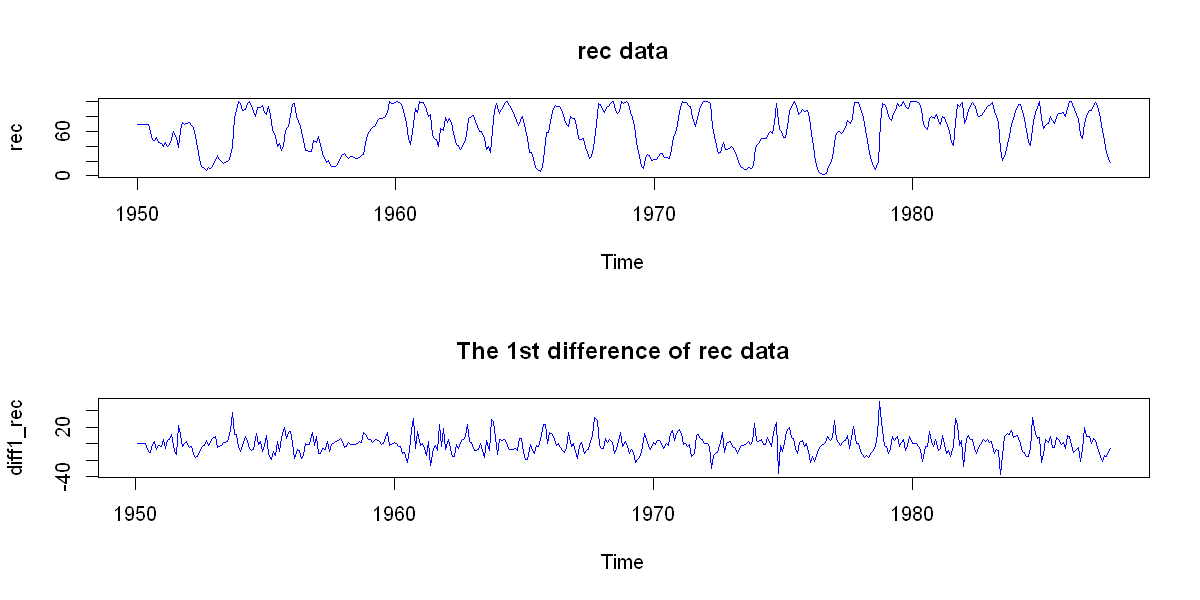

In [56]:
#Step1: Plot time-series

diff1_rec=diff(rec,lag=1)

par(mfrow=c(2,1))
ts.plot(rec, col='blue',main="rec data")
ts.plot(diff1_rec, col='blue', main="The 1st difference of rec data")

#### Step2: Stationary check

Time series data must satisfy the stationarity to fit a timeseries model. The objective way to check stationary is  Dickey-Fuller test. ($H_0$: non-stationary, $H_1$:stationay). We perform the Dickey-Fuller test both rec and __diff1_rec__. 
We observe p-value=0.01<$\alpha$=0.05, so we reject the null hypothesis. Thus, both _rec_ and _diff1_rec_ are stationary. The next step is that find the orders of a time series model.


In [57]:
library(tseries)

In [58]:
tseries::adf.test(rec, alternative="stationary")
tseries::adf.test(diff1_rec, alternative="stationary")

Warning message in tseries::adf.test(rec, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  rec
Dickey-Fuller = -5.4298, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


Warning message in tseries::adf.test(diff1_rec, alternative = "stationary"):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  diff1_rec
Dickey-Fuller = -9.7644, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


#### Step3: Draw ACF, PACF to get information about the order of model. 

_rec_ seems to be having AR(p) models since ACF: Decays zero exponentially, PACF: Cut off. Thus, we consider AR(p). However, this is a subjective way and may not be correct when a possible model is ARIMA. Thus, we use the R function to find an appropriate order for this time series data. 

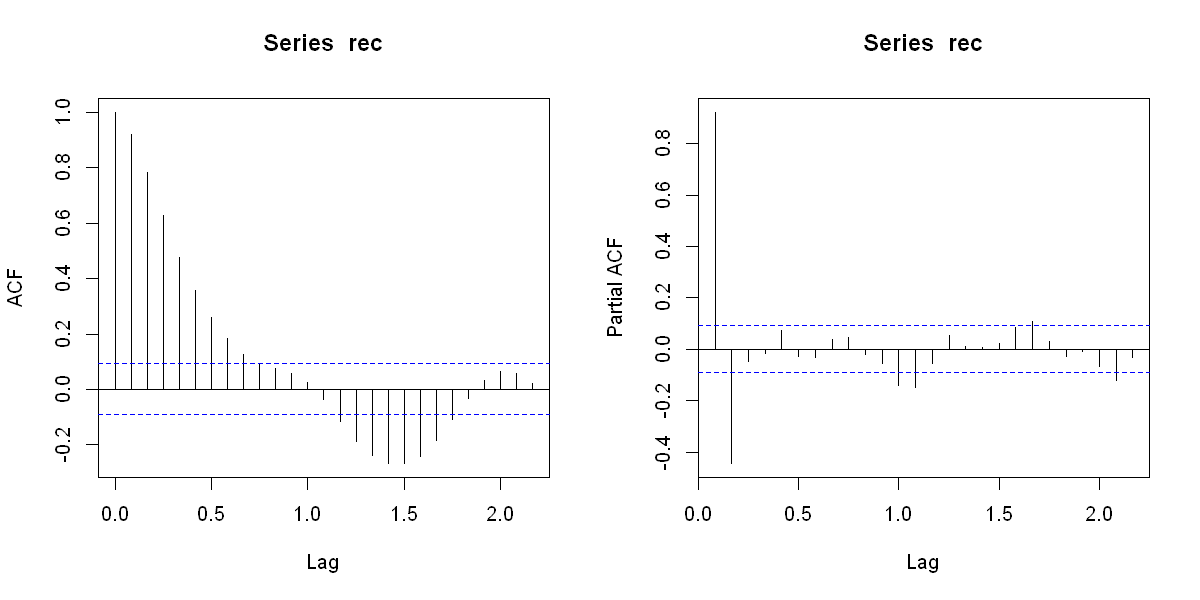

In [59]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
acf(rec)
pacf(rec)

_diff1_rec_ also seems to be having AR(p) models since ACF: Decays zero exponentially, PACF: Cut off. Thus, we consider AR(p). Again, finding exact orders by ACF, PACF is not easy, and this may not be correct. So, we use the R function to find an appropriate order for this time series data.

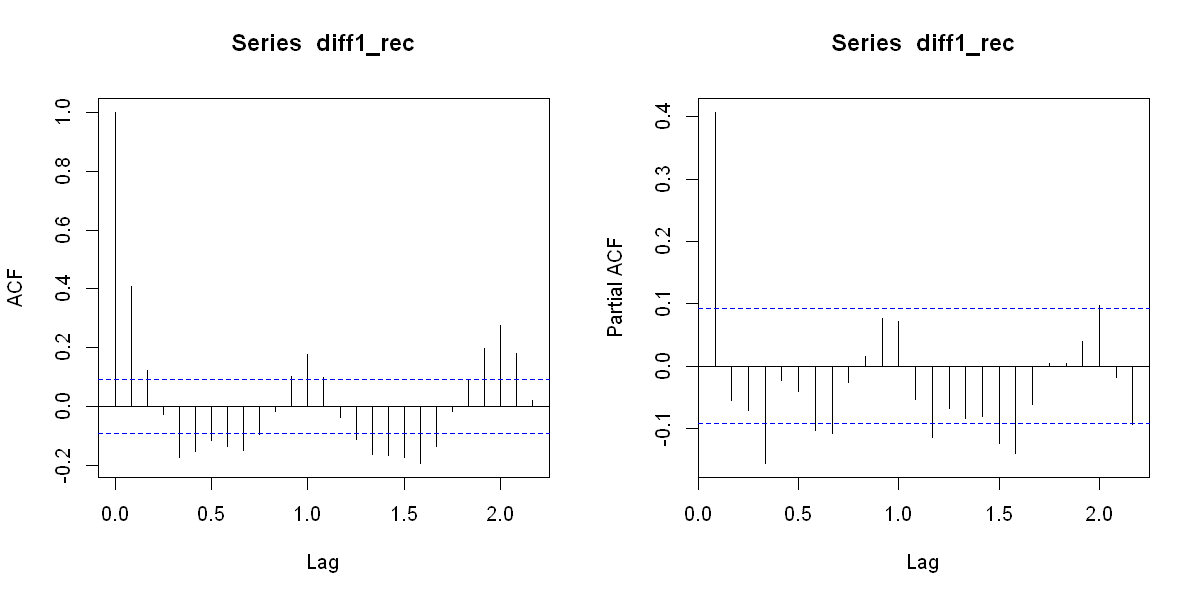

In [60]:
par(mfrow=c(1,2))
acf(diff1_rec)
pacf(diff1_rec)

#### Step4-1: Decide order of ARIMA

In R, auto.arima( ) suggests an appropriate order for the data.  The suggested model is  $ARIMA(p,d,q)(P,D,Q)_m= ARIMA(1,1,0)(0,0,2)_{12}$
The first part (1,1,0) is non-seasonal part of the model. AR(1) with 1st order differencing. The second part (0,0,2) is the seasonal part of the model, and it is MA(2) with season period =12 because Recruitment may be affected by month of year. And we can see the data has some pattern in step 1 time-series plot. Thus, the auto.arima() might have suggested the seasonal part which cannot explained by non-seasonal ARIMA. 
Then the suggested model is 

$$(1-φ_1 B)(1-B)rec_t=(1+\Theta_1 B^{12}+\Theta_2 B^{24})\epsilon_t $$ 

The estimated coefficients are  $\phi=0.3843, \Theta_1=0.0871, \Theta_2=0.1473$.

This model’s residual also satisfies white noise since p-value=0.1872>$\alpha$=0.05

The first output is by auto.arima function. 


In [61]:
library(forecast)

In [62]:
forecast::auto.arima(rec)

Series: rec 
ARIMA(1,1,0)(0,0,2)[12] 

Coefficients:
         ar1    sma1    sma2
      0.3843  0.0871  0.1473
s.e.  0.0437  0.0488  0.0439

sigma^2 = 94.91:  log likelihood = -1669.2
AIC=3346.4   AICc=3346.49   BIC=3362.85

The second R output is by the Arima function. “Fixed “ can specify the zero-coefficients term. _diff1_rec_ is already differentiated. Thus, we do not need to assign the order of d in Arima function. 

Ex) Arima(1,0,24)
The results in Arima are the same as the auto.arima result, $(1-\phi_1 B)(rec_t-rec_{t-1}) =(1+\Theta_1 B^{12}+\Theta_2 B^{24} )\epsilon_t$ 
Thus, we can say the model $(1-\phi_1 B)(1-B)rec_t =(1+\Theta_1 B^{12}+\Theta_2 B^{24} )\epsilon_t$ is well constructed. 


In [63]:
## compare with auto.arima(rec)
fit_seasonal <- Arima(diff1_rec, order=c(1,0,24), fixed=c(NA
                                                  ,0,0,0,0,0,0,0,0,0,0,0,NA
                                                  ,0,0,0,0,0,0,0,0,0,0,0,NA
                                                  ,0))
fit_seasonal
res_fit_seasonal=residuals(fit_seasonal)

Box.test(res_fit_seasonal, lag = 15, type = c("Box-Pierce"), fitdf =3)

Series: diff1_rec 
ARIMA(1,0,24) with non-zero mean 

Coefficients:
         ar1  ma1  ma2  ma3  ma4  ma5  ma6  ma7  ma8  ma9  ma10  ma11    ma12
      0.3843    0    0    0    0    0    0    0    0    0     0     0  0.0871
s.e.  0.0437    0    0    0    0    0    0    0    0    0     0     0  0.0488
      ma13  ma14  ma15  ma16  ma17  ma18  ma19  ma20  ma21  ma22  ma23    ma24
         0     0     0     0     0     0     0     0     0     0     0  0.1473
s.e.     0     0     0     0     0     0     0     0     0     0     0  0.0439
      mean
         0
s.e.     0

sigma^2 = 94.91:  log likelihood = -1669.2
AIC=3346.4   AICc=3346.49   BIC=3362.85


	Box-Pierce test

data:  res_fit_seasonal
X-squared = 16.088, df = 12, p-value = 0.1872


#### Step4-2: Other possible models

Once we decide the time series data does not have seasonality, we __assume__ the data can be explained by only non-seasonal ARIMA. In this case, we can use loop to find optimal p and q by AIC, BIC, and P-value of Box-Pierce Q Test. 

For Q-test, we need to define lag m
m can be chosen between 15 and 30. Usually take $m= T/10, ln(T), \sqrt T$, where T is sample size. 
T of rec=453,  m could be  $ln(453)=7,  \sqrt 453=22, 453/10=45.3$ , But 7 is too small and 45.3 is too large. 
And we set up the upper limit p=5, q= 5. Thus, we deiced to use m=15 (use same m=15 For diff1_rec).


__rec__ : First, we check the p-value of Box-Pierce Q test first. $(H_0:\{\epsilon_t\}$is a white noise process). The marked cells have white noise process at $\alpha$ level 0.05.

<img src="pic1.jpg" alt="isolated" width="500"/>

In  the marked cell, ARIMA(1,0,3) has the lowest AIC and ARIMA(2,0,0) has the lowest BIC. 
Thus, we will fit the ARIMA(1,0,3) and ARIMA(2,0,0) for rec.

<img src="pic2.jpg" alt="isolated" width="500"/>
<img src="pic3.jpg" alt="isolated" width="500"/>

__diff1_rec__ : After we perform Box-Pierce Q test . ($H_0:\{\epsilon_t \}$is a white noise process), we can select combinations of orders which satisfy the white noise process. The marked cells have white noise process (p-value is greater than $\alpha$=0.05) .

<img src="pic4.jpg" alt="isolated" width="500"/>

In  the marked cell, ARIMA (1,1,4) has the lowest AIC and ARIMA (2,1,1) has the lowest BIC. 
Thus, we will fit the ARIMA(1,1,4)  and ARIMA(2,1,1) for _diff1_rec_.

<img src="pic5.jpg" alt="isolated" width="500"/>
<img src="pic6.jpg" alt="isolated" width="500"/>

Therefore,  the possible models are 
* Model1: $ARIMA(1,1,0)(0,0,2)_{12}$
* Model2: $ARIMA(1,0,3)$
* Model3: $ARIMA(2,0,0)$
* Model4: $ARIMA(1,1,4)$
* Model5: $ARIMA(2,1,1)$

In [64]:
#Step4-method2: Decide order of ARIMA
AIC1<-matrix(0,6,6)
BIC1<-matrix(0,6,6)
Pvalue1<-matrix(0,6,6)

for (p in 0:5) {
  for (q in 0:5) {
    model<- Arima(rec, order=c(p,0,q))
    res=residuals(model)
    test=Box.test(res, lag = 15, type = c("Box-Pierce"), fitdf =p+q)
    p.value=test$p.value
    
    AIC1[p+1,q+1] <- AIC(model)
    BIC1[p+1,q+1] <- BIC(model)
    Pvalue1[p+1,q+1] <- p.value
  }
}

AIC1
BIC1
Pvalue1

4306.794,3833.724,3599.712,3463.032,3392.175,3360.568
3437.273,3353.097,3343.441,3330.481,3332.115,3334.026
3331.019,3332.165,3334.152,3332.162,3334.016,3336.070
3332.215,3334.545,3334.805,3334.111,3335.986,3336.485
3333.982,3334.355,3332.659,3335.446,3338.122,3336.400
3333.336,3334.842,3334.658,3337.465,3339.458,3341.436


4315.025,3846.072,3616.176,3483.612,3416.870,3389.380
3449.621,3369.560,3364.020,3355.176,3360.926,3366.954
3347.483,3352.744,3358.847,3360.973,3366.943,3373.113
3352.795,3359.240,3363.616,3367.038,3373.029,3377.644
3358.678,3363.166,3365.586,3372.489,3379.281,3381.675
3362.147,3367.769,3371.701,3378.624,3384.732,3390.827


0.00000000,0.0000000000,0.000000000,0.00000000,2.131628e-14,1.089417e-05
0.00000000,0.0000738378,0.003858304,0.16806911,1.248107e-01,9.285075e-02
0.11735529,0.0709700381,0.048492922,0.12236129,9.175992e-02,5.785173e-02
0.07215734,0.0697344581,0.045418536,0.09094543,6.187017e-02,4.544531e-02
0.04758486,0.0455046897,0.068116394,0.06540505,3.752144e-02,2.703056e-02
0.05963451,0.0514970422,0.042573312,0.03868518,2.174398e-02,1.069304e-02


In [65]:
AIC2<-matrix(0,6,6)
BIC2<-matrix(0,6,6)
Pvalue2<-matrix(0,6,6)

for (p in 0:5) {
  for (q in 0:5) {
    model<- Arima(diff1_rec, order=c(p,0,q))
    res=residuals(model)
    test=Box.test(res, lag = 15, type = c("Box-Pierce"), fitdf =p+q)
    p.value=test$p.value
    
    AIC2[p+1,q+1] <- AIC(model)
    BIC2[p+1,q+1] <- BIC(model)
    Pvalue2[p+1,q+1] <- p.value
    }
}

AIC2
BIC2
Pvalue2

3442.872,3369.121,3365.260,3362.743,3361.268,3356.614
3363.206,3364.178,3365.883,3363.603,3326.381,3327.948
3363.896,3326.790,3327.782,3359.021,3327.994,3329.865
3363.707,3327.854,3330.330,3360.764,3329.979,3331.866
3354.635,3329.542,3329.905,3328.334,3331.160,3333.152
3356.372,3329.114,3330.590,3330.641,3333.170,3334.956


3451.099,3381.462,3381.715,3383.311,3385.950,3385.410
3375.547,3380.632,3386.451,3388.285,3355.176,3360.857
3380.351,3347.359,3352.464,3387.817,3360.903,3366.888
3384.275,3352.536,3359.126,3393.673,3367.002,3373.003
3379.317,3358.338,3362.814,3365.357,3372.297,3378.402
3385.168,3362.023,3367.613,3371.778,3378.420,3384.320


0.0000000000,2.242423e-05,0.0003534628,0.002011979,0.002388307,0.01215952
0.0005761913,6.950956e-04,0.0004429362,0.001523984,0.118761224,0.08538562
0.0008557478,8.730676e-02,0.0508837550,0.011042299,0.082875295,0.05929734
0.0012387064,5.179058e-02,0.0477977649,0.005552357,0.057557344,0.03634853
0.0236535243,3.335378e-02,0.0313977444,0.045443879,0.041129665,0.02272413
0.0118678329,3.673291e-02,0.0309710625,0.028317944,0.022589018,0.01190298


#### Step5: Check the model ACF of Models’ residual

Our all possible five function has similar ACF, BIC. We see that $\epsilon_t$ is white noise, which means $cov(\epsilon_t,\epsilon_{t-k})=0$ with k>0.  However, when we draw graphs of ACF of model’s residual, The model1's acf  is less deviated from the confidence interval than other models. 
Thus, I will choose the Model5, and the estimated model is
(1-0.3843B)(1-B) (〖rec〗_t ) ̂=(1+0.0871B^12+0.1473B^24 ) ɛ ̂_t


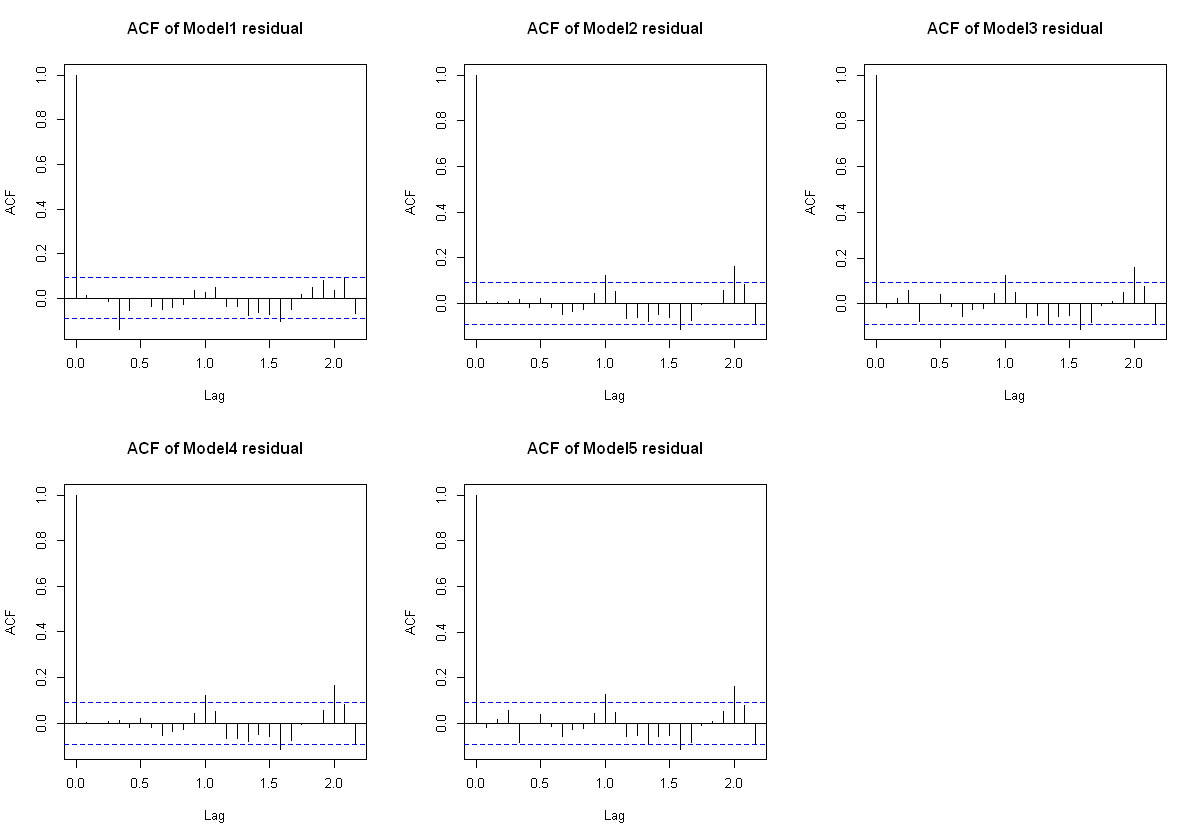

In [68]:
fit1 <- Arima(rec, order=c(1,1,0), seasonal=c(0,0,2))
fit2 <- Arima(rec, order=c(1,0,3))
fit3 <- Arima(rec, order=c(2,0,0))
fit4 <- Arima(rec, order=c(1,1,4))
fit5 <- Arima(rec, order=c(2,1,1))


res1 <-residuals(fit1)
res2 <-residuals(fit2)
res3 <-residuals(fit3)
res4 <-residuals(fit4)
res5 <-residuals(fit5)

options(repr.plot.width=10, repr.plot.height=7)
par(mfrow=c(2,3))
acf(res1, main="ACF of Model1 residual")
acf(res2, main="ACF of Model2 residual")
acf(res3, main="ACF of Model3 residual")
acf(res4, main="ACF of Model4 residual")
acf(res5, main="ACF of Model5 residual")